In [1]:
# Assignment 3
# Jian Zhang, student ID: 219012058
# Date: 19.11.12

In [2]:
# import necessary library
import numpy as np
import pandas as pd
import math
import sys
import cv2 # use opencv to read image
import matplotlib.pyplot as plt # use matplotlib to show image
from random import randint
from skimage import morphology
from math import ceil, floor
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.utils import shuffle
import os
from PIL import Image
from sklearn.ensemble import AdaBoostClassifier

In [3]:
# Exercise 1: Texture
# implement the texture synthesis algorithm
# modified by https://github.com/goldbema/TextureSynthesis/blob/master/synthesis.py
# algorithm details: https://people.eecs.berkeley.edu/~efros/research/EfrosLeung.html

In [32]:
EIGHT_CONNECTED_NEIGHBOR_KERNEL = np.array([[1., 1., 1.],
                                            [1., 0., 1.],
                                            [1., 1., 1.]], dtype=np.float64)
SIGMA_COEFF = 6.4      # The denominator for a 2D Gaussian sigma used in the reference implementation.
ERROR_THRESHOLD = 0.1  # The default error threshold for synthesis acceptance in the reference implementation.


def normalized_ssd(sample, window, mask):
    wh, ww = window.shape
    sh, sw = sample.shape

    # Get sliding window views of the sample, window, and mask.
    strided_sample = np.lib.stride_tricks.as_strided(sample, shape=((sh-wh+1), (sw-ww+1), wh, ww), 
                        strides=(sample.strides[0], sample.strides[1], sample.strides[0], sample.strides[1]))
    strided_sample = strided_sample.reshape(-1, wh, ww)

    # Note that the window and mask views have the same shape as the strided sample, but the kernel is fixed
    # rather than sliding for each of these components.
    strided_window = np.lib.stride_tricks.as_strided(window, shape=((sh-wh+1), (sw-ww+1), wh, ww),
                        strides=(0, 0, window.strides[0], window.strides[1]))
    strided_window = strided_window.reshape(-1, wh, ww)

    strided_mask = np.lib.stride_tricks.as_strided(mask, shape=((sh-wh+1), (sw-ww+1), wh, ww),
                        strides=(0, 0, mask.strides[0], mask.strides[1]))
    strided_mask = strided_mask.reshape(-1, wh, ww)

    # Form a 2D Gaussian weight matrix from symmetric linearly separable Gaussian kernels and generate a 
    # strided view over this matrix.
    sigma = wh / SIGMA_COEFF
    kernel = cv2.getGaussianKernel(ksize=wh, sigma=sigma)
    kernel_2d = kernel * kernel.T

    strided_kernel = np.lib.stride_tricks.as_strided(kernel_2d, shape=((sh-wh+1), (sw-ww+1), wh, ww),
                        strides=(0, 0, kernel_2d.strides[0], kernel_2d.strides[1]))
    strided_kernel = strided_kernel.reshape(-1, wh, ww)

    # Take the sum of squared differences over all sliding sample windows and weight it so that only existing neighbors
    # contribute to error. Use the Gaussian kernel to weight central values more strongly than distant neighbors.
    squared_differences = ((strided_sample - strided_window)**2) * strided_kernel * strided_mask
    ssd = np.sum(squared_differences, axis=(1,2))
    ssd = ssd.reshape(sh-wh+1, sw-ww+1)

    # Normalize the SSD by the maximum possible contribution.
    total_ssd = np.sum(mask * kernel_2d)
    normalized_ssd = ssd / total_ssd

    return normalized_ssd

def get_candidate_indices(normalized_ssd, error_threshold=ERROR_THRESHOLD):
    min_ssd = np.min(normalized_ssd)
    min_threshold = min_ssd * (1. + error_threshold)
    indices = np.where(normalized_ssd <= min_threshold)
    return indices

def select_pixel_index(normalized_ssd, indices, method='uniform'):
    N = indices[0].shape[0]

    if method == 'uniform':
        weights = np.ones(N) / float(N)
    else:
        weights = normalized_ssd[indices]
        weights = weights / np.sum(weights)

    # Select a random pixel index from the index list.
    selection = np.random.choice(np.arange(N), size=1, p=weights)
    selected_index = (indices[0][selection], indices[1][selection])
    
    return selected_index

def get_neighboring_pixel_indices(pixel_mask):
    # Taking the difference between the dilated mask and the initial mask
    # gives only the 8-connected neighbors of the mask frontier.
    kernel = np.ones((3,3))
    dilated_mask = cv2.dilate(pixel_mask, kernel, iterations=1)
    neighbors = dilated_mask - pixel_mask

    # Recover the indices of the mask frontier.
    neighbor_indices = np.nonzero(neighbors)

    return neighbor_indices

def permute_neighbors(pixel_mask, neighbors):
    N = neighbors[0].shape[0]

    # Generate a permutation of the neigboring indices
    permuted_indices = np.random.permutation(np.arange(N))
    permuted_neighbors = (neighbors[0][permuted_indices], neighbors[1][permuted_indices])

    # Use convolution to count the number of existing neighbors for all entries in the mask.
    neighbor_count = cv2.filter2D(pixel_mask, ddepth=-1, kernel=EIGHT_CONNECTED_NEIGHBOR_KERNEL, borderType=cv2.BORDER_CONSTANT)

    # Sort the permuted neighboring indices by quantity of existing neighbors descending.
    permuted_neighbor_counts = neighbor_count[permuted_neighbors]

    sorted_order = np.argsort(permuted_neighbor_counts)[::-1]
    permuted_neighbors = (permuted_neighbors[0][sorted_order], permuted_neighbors[1][sorted_order])

    return permuted_neighbors

def texture_can_be_synthesized(mask):
    # The texture can be synthesized while the mask has unfilled entries.
    mh, mw = mask.shape[:2]
    num_completed = np.count_nonzero(mask)
    num_incomplete = (mh * mw) - num_completed
    
    return num_incomplete > 0

def initialize_texture_synthesis(original_sample, window_size, kernel_size):

    # Convert original to sample representation.
    sample = cv2.cvtColor(original_sample, cv2.COLOR_BGR2GRAY)
    
    # Convert sample to floating point and normalize to the range [0., 1.]
    sample = sample.astype(np.float64)
    sample = sample / 255.

    # Generate window
    window = np.zeros(window_size, dtype=np.float64)

    # Generate output window
    if original_sample.ndim == 2:
        result_window = np.zeros_like(window, dtype=np.uint8)
    else:
        result_window = np.zeros(window_size + (3,), dtype=np.uint8)

    # Generate window mask
    h, w = window.shape
    mask = np.zeros((h, w), dtype=np.float64)

    # Initialize window with random seed from sample
    sh, sw = original_sample.shape[:2]
    ih = np.random.randint(sh-3+1)
    iw = np.random.randint(sw-3+1)
    seed = sample[ih:ih+3, iw:iw+3]

    # Place seed in center of window
    ph, pw = (h//2)-1, (w//2)-1
    window[ph:ph+3, pw:pw+3] = seed
    mask[ph:ph+3, pw:pw+3] = 1
    result_window[ph:ph+3, pw:pw+3] = original_sample[ih:ih+3, iw:iw+3]

    # Obtain padded versions of window and mask
    win = kernel_size//2
    padded_window = cv2.copyMakeBorder(window, 
                                       top=win, bottom=win, left=win, right=win, borderType=cv2.BORDER_CONSTANT, value=0.)
    padded_mask = cv2.copyMakeBorder(mask,
                                     top=win, bottom=win, left=win, right=win, borderType=cv2.BORDER_CONSTANT, value=0.)
    
    # Obtain views of the padded window and mask
    window = padded_window[win:-win, win:-win]
    mask = padded_mask[win:-win, win:-win]

    return sample, window, mask, padded_window, padded_mask, result_window
    
def synthesize_texture(original_sample, window_size, kernel_size):
    
    (sample, window, mask, padded_window, 
        padded_mask, result_window) = initialize_texture_synthesis(original_sample, window_size, kernel_size)

    # Synthesize texture until all pixels in the window are filled.
    while texture_can_be_synthesized(mask):
        # Get neighboring indices
        neighboring_indices = get_neighboring_pixel_indices(mask)

        # Permute and sort neighboring indices by quantity of 8-connected neighbors.
        neighboring_indices = permute_neighbors(mask, neighboring_indices)
        
        for ch, cw in zip(neighboring_indices[0], neighboring_indices[1]):

            window_slice = padded_window[ch:ch+kernel_size, cw:cw+kernel_size]
            mask_slice = padded_mask[ch:ch+kernel_size, cw:cw+kernel_size]

            # Compute SSD for the current pixel neighborhood and select an index with low error.
            ssd = normalized_ssd(sample, window_slice, mask_slice)
            indices = get_candidate_indices(ssd)
            selected_index = select_pixel_index(ssd, indices)

            # Translate index to accommodate padding.
            selected_index = (selected_index[0] + kernel_size // 2, selected_index[1] + kernel_size // 2)

            # Set windows and mask.
            window[ch, cw] = sample[selected_index]
            mask[ch, cw] = 1
            result_window[ch, cw] = original_sample[selected_index[0], selected_index[1]]

    return result_window

In [38]:
# use the image 'brick.png' to synthesize a 1000*1000 image

img_brick = cv2.imread('brick.png') 
brick_height = img_brick.shape[0]
brick_width  = img_brick.shape[1]
output_height = 1000
output_width  = 1000
PatchSize  = 50 # 88 is the solution but it cannot be divisible by 1000, 50 is good enough

synthesized_texture = synthesize_texture(original_sample=img_brick, 
                                         window_size=(output_height, output_width), 
                                         kernel_size=PatchSize)

In [36]:
# output synthesized texture
cv2.imwrite('synthesized.jpg', synthesized_texture)

True

In [ ]:
# Exercise 2: Segmentation
img_dayun = cv2.imread('dayun.jpg') 
img_tanglang = cv2.imread('tanglang.jpg') 
# Convert to floats instead of the default 8 bits integer coding. 
# Dividing by 255 is important so that plt.imshow behaves works well on float data
# need to be in the range [0-1]
# img_dayun = np.array(img_dayun, dtype=np.float64) / 255
# img_tanglang = np.array(img_tanglang, dtype=np.float64) / 255

In [ ]:
dayun_height = img_dayun.shape[0]
dayun_width  = img_dayun.shape[1]
dayun_array = np.reshape(img_dayun, (dayun_height * dayun_width, 3))

In [ ]:
x = np.arange(0, dayun_height)
y = np.arange(0, dayun_width)
xx, yy = np.meshgrid(y, x)
xxx, yyy = xx.flatten(), yy.flatten()

In [ ]:
# generate data vector, select proper weights
dayun_feature = np.c_[dayun_array / 255, yyy / dayun_height, xxx / dayun_width]

In [ ]:
dayun_sample = shuffle(dayun_feature, random_state=0)[:100000]
kmeans = KMeans(n_clusters=5, n_jobs=-1).fit(dayun_sample)
labels = kmeans.predict(dayun_feature)
kmeans_dayun = labels.reshape([dayun_height, dayun_width])
cv2.imwrite('kmeans_dayun.jpg', kmeans_dayun * int(256 / 4))

In [ ]:
tanglang_height = img_tanglang.shape[0]
tanglang_width  = img_tanglang.shape[1]
tanglang_array = np.reshape(img_tanglang, (tanglang_height * tanglang_width, 3))
x = np.arange(0, tanglang_height)
y = np.arange(0, tanglang_width)
xx, yy = np.meshgrid(y, x)
xxx, yyy = xx.flatten(), yy.flatten()

In [ ]:
# generate data vector, select proper weights
tanglang_feature = np.c_[tanglang_array / 255, yyy / tanglang_height, xxx / tanglang_width]

In [ ]:
tanglang_sample = shuffle(tanglang_feature, random_state=0)[:100000]
kmeans = KMeans(n_clusters=5, n_jobs=-1).fit(tanglang_sample)
tanglang_label = kmeans.predict(tanglang_feature)
kmeans_tanglang = tanglang_label.reshape([tanglang_height, tanglang_width])
cv2.imwrite('kmeans_tanglang.jpg', kmeans_tanglang * int(256 / 4))

In [49]:
# Exercise 3: Face Detection
# modified from https://github.com/Simon-Hohberg/Viola-Jones

# turn a image array into integral image, return type ndarray
def to_integral_image(img_arr):

    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    for x in range(img_arr.shape[1]):
        for y in range(img_arr.shape[0]):
            row_sum[y, x] = row_sum[y-1, x] + img_arr[y, x]
            integral_image_arr[y+1, x+1] = integral_image_arr[y+1, x-1+1] + row_sum[y, x]
    return integral_image_arr

In [50]:
def sum_region(integral_img_arr, top_left, bottom_right):
    """
    Calculates the sum in the rectangle specified by the given tuples.
    :param integral_img_arr:
    :type integral_img_arr: numpy.ndarray
    :param top_left: (x, y) of the rectangle's top left corner
    :type top_left: (int, int)
    :param bottom_right: (x, y) of the rectangle's bottom right corner
    :type bottom_right: (int, int)
    :return The sum of all pixels in the given rectangle
    :rtype int
    """
    # swap tuples
    top_left = (top_left[1], top_left[0])
    bottom_right = (bottom_right[1], bottom_right[0])
    if top_left == bottom_right:
        return integral_img_arr[top_left]
    top_right = (bottom_right[0], top_left[1])
    bottom_left = (top_left[0], bottom_right[1])
    return integral_img_arr[bottom_right] - integral_img_arr[top_right] - integral_img_arr[bottom_left] + integral_img_arr[top_left]

In [51]:
def load_images(path):
    images = []
    for _file in os.listdir(path):
        if _file.endswith('.jpg') or _file.endswith('pgm'):
            img_arr = np.array(Image.open((os.path.join(path, _file))).convert('L'), dtype=np.float64)
            img_arr /= img_arr.max()
            images.append(img_arr)
    return images

In [52]:
# load lfw images and nonface images
nonface_path = './face_detection/nonface'
lfw_path = './face_detection/lfw1000'
nonface_images = load_images(nonface_path)
lfw_images = load_images(lfw_path)

In [53]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]


class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: violajonse.HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score

In [54]:
def create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                for x in range(img_width - feature_width):
                    for y in range(img_height - feature_height):
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, 1))
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, -1))
    return features

In [55]:
num_classifiers = 2
# For performance reasons restricting feature size
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

img_height, img_width = lfw_images[0].shape
features = create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

In [56]:
# generate train positive set
train_df = pd.DataFrame()
train_pos_images = lfw_images[:100]
for img in train_pos_images:
    
    int_img = to_integral_image(img)
    current_features = []
    for feature in features:
        current_features.append(feature.get_score(int_img))
    np_features = np.array(current_features).reshape(1,-1)
    tmp_df = pd.DataFrame(np_features)
    tmp_df['label'] = 1
    train_df = pd.concat([train_df, tmp_df])

In [57]:
# generate train negative set
# randomly crop 64*64 size images from original images
train_neg_images = []
for neg_img in nonface_images[:10]:
    count = 0
    while count < 10:
        h = randint(0, neg_img.shape[0] - img_height)
        w = randint(0, neg_img.shape[1] - img_width)
        cropImg = neg_img[(h):(h + img_height - 1), (w):(w + img_width - 1)]
        int_img = to_integral_image(cropImg)
        train_neg_images.append(int_img)
        
        count += 1

In [58]:
for img in train_neg_images:
    
    int_img = to_integral_image(img)
    current_features = []
    for feature in features:
        current_features.append(feature.get_score(int_img))
    np_features = np.array(current_features).reshape(1,-1)
    tmp_df = pd.DataFrame(np_features)
    tmp_df['label'] = 0
    train_df = pd.concat([train_df, tmp_df])

train_df = train_df.reset_index(drop=True)

In [59]:
# generate test set for positive image
test_pos_df = pd.DataFrame()
test_pos_images = lfw_images[100:200]
for img in test_pos_images:
    
    int_img = to_integral_image(img)
    current_features = []
    for feature in features:
        current_features.append(feature.get_score(int_img))
    np_features = np.array(current_features).reshape(1,-1)
    tmp_df = pd.DataFrame(np_features)
    test_pos_df = pd.concat([test_pos_df, tmp_df])
test_pos_df = test_pos_df.reset_index(drop=True)

In [60]:
# generate test set for negative image
# test_neg_df = pd.DataFrame()
# test_neg_images = nonface_images[40:60]
# for img in test_neg_images:
    
#     img_resized = cv2.resize(img, (img_height, img_width))
#     int_img = to_integral_image(img_resized)
#     current_features = []
#     for feature in features:
#         current_features.append(feature.get_score(int_img))
#     np_features = np.array(current_features).reshape(1,-1)
#     tmp_df = pd.DataFrame(np_features)
#     test_neg_df = pd.concat([test_neg_df, tmp_df])
# test_neg_df = test_neg_df.reset_index(drop=True)

In [61]:
# training with adaboost classifier
model = AdaBoostClassifier()
model.fit(train_df.iloc[:, :-1], train_df['label'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [62]:
model.predict(test_pos_df)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

<function matplotlib.pyplot.show(*args, **kw)>

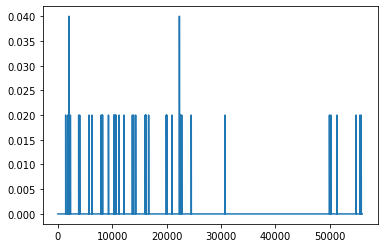

In [212]:
# select strong features for cascaded classifier
plt.plot(model.feature_importances_)
plt.show()

In [252]:
# stored high importance features index
maxindex = np.argsort(-model.feature_importances_)[:2000]

In [261]:
# construct a cascaded classfier
# looking at 2, 10, 50, 200, 2000 features
model_features_2 = AdaBoostClassifier()
model_features_2.fit(train_df.iloc[:, maxindex[:2]], train_df['label'])
model_features_10 = AdaBoostClassifier()
model_features_10.fit(train_df.iloc[:, maxindex[:10]], train_df['label'])
model_features_50 = AdaBoostClassifier()
model_features_50.fit(train_df.iloc[:, maxindex[:50]], train_df['label'])
model_features_200 = AdaBoostClassifier()
model_features_200.fit(train_df.iloc[:, maxindex[:200]], train_df['label'])
model_features_2000 = AdaBoostClassifier()
model_features_2000.fit(train_df.iloc[:, maxindex[:2000]], train_df['label'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [271]:
# we use sorted features importance in adaboost
# use simple and strong classifier first, then we reject those nonface images
# otherwise, we continue to next classifier
def cascaded(features):
    
    label = model_features_2.predict(features[:,maxindex[:2]])
    if label == 0:
        return 0
    label = model_features_10.predict(features[:,maxindex[:10]])
    if label == 0:
        return 0
    label = model_features_50.predict(features[:,maxindex[:50]])
    if label == 0:
        return 0
    label = model_features_200.predict(features[:,maxindex[:200]])
    if label == 0:
        return 0
    label = model_features_2000.predict(features[:,maxindex[:2000]])
    if label == 0:
        return 0
    label = model.predict(features)
    if label == 0:
        return 0
    
    return 1

In [263]:
# test on Solvay.jpg and Big3.jpg
img_solvay = cv2.imread('./face_detection/Solvay.jpg', 0) 
img_big3 = cv2.imread('./face_detection/Big3.jpg', 0)

In [276]:
stride = 32
h_solvay, w_solvay = img_solvay.shape

face_location = []
for h in range(0, h_solvay - img_height, stride):
    for w in range(0, w_solvay - img_width, stride):
        cropImg = img_solvay[(h):(h + img_height - 1), (w):(w + img_width - 1)]
        int_img = to_integral_image(cropImg)
        current_features = []
        for feature in features:
            current_features.append(feature.get_score(int_img))
        current_features = np.array(current_features).reshape(1,-1)
        if cascaded(current_features):
            print('find one face, location:', h, w)
            face_location.append((h,w))
            w += img_width

In [275]:
stride = 32
h_big3, w_big3 = img_big3.shape

face_location = []
for h in range(0, h_big3 - img_height, stride):
    for w in range(0, w_big3 - img_width, stride):
        cropImg = img_big3[(h):(h + img_height - 1), (w):(w + img_width - 1)]
        int_img = to_integral_image(cropImg)
        current_features = []
        for feature in features:
            current_features.append(feature.get_score(int_img))
        current_features = np.array(current_features).reshape(1,-1)
        if cascaded(current_features):
            print('find one face, location:', h, w)
            face_location.append((h,w))
            w += img_width

find one face, location: 192 320
find one face, location: 192 576
find one face, location: 256 544
find one face, location: 320 288
find one face, location: 352 32
